# import des données

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

ml_client = MLClient(
    credential=DefaultAzureCredential(),
    subscription_id="72eb7803-e874-44cb-b6d9-33f2fa3eb88c",
    resource_group_name="vpoutotrg",
    workspace_name="mlstudio-groupe4"
)

data_asset = ml_client.data.get("allo_cine", version="2.2.3")

df = pd.read_parquet(data_asset.path)
df = df[df['french_first_week_boxoffice'].notna()]
df["date"] = pd.to_datetime(df["date"], format='%Y-%m-%d', errors='coerce')
df = df[df['date'].notna()]
df['us_first_week_boxoffice'] = df['us_first_week_boxoffice'].fillna(0)
# import pyarrow as pa
# import pyarrow.parquet as pq
# table = pa.Table.from_pandas(df)
# pq.write_table(table, "gros_data.parquet")
df.drop(['langage_target_transform', 'genre_target_transform', 'actors_target_transform', 'nationality_target_transform'], axis=1)
df.head()

Overriding of current TracerProvider is not allowed
Overriding of current LoggerProvider is not allowed
Overriding of current MeterProvider is not allowed
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Overriding of current TracerProvider is not allowed
Overriding of current LoggerProvider is not allowed
Overriding of current MeterProvider is not allowed
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented


,actors,critics_score,date,directors,editor,genre,langage,length,nationality,viewers_score,...,langage_second_target_transform,langage_third_target_transform,nationality_target_transform,nationality_first_target_transform,nationality_second_target_transform,nationality_third_target_transform,actors_target_transform,actors_first_target_transform,actors_second_target_transform,actors_third_target_transform
0,"[Arieh Worthalter, Arthur Harari, Stéphan Guér...",4.4,2023-09-27,[Cédric Kahn],Ad Vitam,"[Policier, Drame, Historique, Judiciaire]",[Français],116.0,[France],3.9,...,0.000000,0.000000,[124385.11141427922],124385.111414,0.000000,0.000000,"[239984.0, 200525.5, 143569.16666666666, 11712...",2.399840e+05,2.005255e+05,1.435692e+05
1,"[Monica Bellucci, Vincent Cassel, Albert Dupon...",3.5,2020-08-26,[Gaspar Noé],Carlotta Films,"[Drame, Thriller]","[Anglais, Français, Italien, Espagnol]",90.0,[France],NaN,...,293844.488927,140604.275081,[124385.11141427922],124385.111414,0.000000,0.000000,"[531123.0322580645, 465677.8333333333, 421508....",5.311230e+05,4.656778e+05,4.215080e+05
2,[Thom Hoffman],2.8,2024-08-07,"[Richard Claus, Karsten Kiilerich]",Le Pacte,"[Aventure, Animation, Comédie, Famille]",[Néerlandais],84.0,"[Danemark, France, Allemagne, Pays-Bas]",3.0,...,0.000000,0.000000,"[363953.98756906076, 124385.11141427922, 44294...",363953.987569,124385.111414,44294.738739,[83625.0],8.362500e+04,0.000000e+00,0.000000e+00
3,"[Lou de Laâge, Raphaël Personnaz, Isabelle Car...",3.3,2022-12-21,[Olivier Treiner],SND,[Drame],[Français],120.0,[France],3.8,...,0.000000,0.000000,[124385.11141427922],124385.111414,0.000000,0.000000,"[211751.9516129032, 155513.89285714287, 149979...",2.117520e+05,1.555139e+05,1.499798e+05
4,"[Michael B. Jordan, Jamie Foxx, Brie Larson, R...",3.0,2020-01-29,[Destin Daniel Cretton],Warner Bros. France,"[Biopic, Drame]",[Anglais],137.0,[U.S.A.],4.1,...,0.000000,0.000000,[876430.8766368022],876430.876637,0.000000,0.000000,"[3880101.0, 2556312.8333333335, 1410191.0, 631...",3.880101e+06,2.556313e+06,1.410191e+06


In [30]:
df = pd.read_parquet("targuet_transform2.parquet")
df.head(2)

,actors,critics_score,date,directors,editor,genre,langage,length,nationality,viewers_score,us_first_week_boxoffice,french_first_week_boxoffice,french_visa,title,vo_title,url,genre_target_transform,genre_first_target_transform,genre_second_target_transform,genre_third_target_transform,langage_target_transform,langage_first_target_transform,langage_second_target_transform,langage_third_target_transform,nationality_target_transform,nationality_first_target_transform,nationality_second_target_transform,nationality_third_target_transform,directors_target_transform,directors_first_target_transform,directors_second_target_transform,directors_third_target_transform,actors_target_transform,actors_first_target_transform,actors_second_target_transform,actors_third_target_transform
0,"[Arieh Worthalter, Arthur Harari, Stéphan Guér...",4.4,2023-09-27,[Cédric Kahn],Ad Vitam,"[Policier, Drame, Historique, Judiciaire]",[Français],116.0,[France],3.9,NaN,110011.0,157303,Le Procès Goldman,None,/article/fichearticle_gen_carticle=1000093547....,"[420527.52818371606, 268761.8012820513, 189607...",420527.528184,268761.801282,189607.90625,[140468.08722657306],140468.087227,0.000000,0.000000,[124385.11141427922],124385.111414,0.0,0.0,[112894.25],112894.25,0.0,0.0,"[239984.0, 200525.5, 143569.16666666666, 11712...",239984.000000,200525.500000,143569.166667
1,"[Monica Bellucci, Vincent Cassel, Albert Dupon...",3.5,2020-08-26,[Gaspar Noé],Carlotta Films,"[Drame, Thriller]","[Anglais, Français, Italien, Espagnol]",90.0,[France],NaN,NaN,2905.0,153336,Irréversible - Inversion Intégrale,None,/article/fichearticle_gen_carticle=18692477.html,"[381754.50692307693, 141083.3410065448]",381754.506923,141083.341007,0.00000,"[674122.5056439199, 293844.4889267462, 140604....",674122.505644,293844.488927,140604.275081,[124385.11141427922],124385.111414,0.0,0.0,[37985.5],37985.50,0.0,0.0,"[531123.0322580645, 465677.8333333333, 421508....",531123.032258,465677.833333,421508.000000


In [31]:
pd.set_option('display.max_columns', None)
df.head(1)

,actors,critics_score,date,directors,editor,genre,langage,length,nationality,viewers_score,us_first_week_boxoffice,french_first_week_boxoffice,french_visa,title,vo_title,url,genre_target_transform,genre_first_target_transform,genre_second_target_transform,genre_third_target_transform,langage_target_transform,langage_first_target_transform,langage_second_target_transform,langage_third_target_transform,nationality_target_transform,nationality_first_target_transform,nationality_second_target_transform,nationality_third_target_transform,directors_target_transform,directors_first_target_transform,directors_second_target_transform,directors_third_target_transform,actors_target_transform,actors_first_target_transform,actors_second_target_transform,actors_third_target_transform
0,"[Arieh Worthalter, Arthur Harari, Stéphan Guér...",4.4,2023-09-27,[Cédric Kahn],Ad Vitam,"[Policier, Drame, Historique, Judiciaire]",[Français],116.0,[France],3.9,NaN,110011.0,157303,Le Procès Goldman,None,/article/fichearticle_gen_carticle=1000093547....,"[420527.52818371606, 268761.8012820513, 189607...",420527.528184,268761.801282,189607.90625,[140468.08722657306],140468.087227,0.0,0.0,[124385.11141427922],124385.111414,0.0,0.0,[112894.25],112894.25,0.0,0.0,"[239984.0, 200525.5, 143569.16666666666, 11712...",239984.0,200525.5,143569.166667


In [32]:
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

file_name = "cncAffluence"
version="2.0.0"

data_asset = ml_client.data.get(file_name, version=version)

df_afluence = pd.read_parquet(data_asset.path)
df_afluence.head()

,box_office,is_prediction
month,,
2009-01-01,15.148333,0
2009-02-01,19.348000,0
2009-03-01,20.087500,0
2009-04-01,16.975000,0
2009-05-01,14.528333,0


In [33]:
file_name = "cncAffluence"
version="2.0.1"
data_asset = ml_client.data.get(file_name, version=version)

df_afluence_filled = pd.read_parquet(data_asset.path)
# import pyarrow as pa
# import pyarrow.parquet as pq
# table = pa.Table.from_pandas(df_afluence_filled)
# pq.write_table(table, "affluence_docker.parquet")
df_afluence_filled.head()

,box_office,is_prediction
month,,
1989-01-01,9.822903,1.0
1989-02-01,11.884946,1.0
1989-03-01,11.417790,1.0
1989-04-01,10.506531,1.0
1989-05-01,9.071718,1.0


In [34]:
file_name = "actors_jpbox"
version="2.0"

ml_client = MLClient(
    credential=DefaultAzureCredential(),
    subscription_id="72eb7803-e874-44cb-b6d9-33f2fa3eb88c",
    resource_group_name="vpoutotrg",
    workspace_name="mlstudio-groupe4"
)

data_asset = ml_client.data.get(file_name, version=version)

df_actors = pd.read_parquet(data_asset.path)
df_actors['name'] = df_actors["name"].apply(lambda x : x.replace(" ", "").replace("-", "").replace("_", "").strip().lower())
df_actors.set_index('name', inplace=True)
# import pyarrow as pa
# import pyarrow.parquet as pq
# table = pa.Table.from_pandas(df_actors)
# pq.write_table(table, "actors.parquet")
df_actors.head()

Overriding of current TracerProvider is not allowed
Overriding of current LoggerProvider is not allowed
Overriding of current MeterProvider is not allowed
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented


,amount_of_film_played_in,boxoffice_average,boxoffice_average_first_role,boxoffice_total,boxoffice_total_first_role,nationality,rank
name,,,,,,,
jasonsegel,15,197655,284469,3360134,2275749,américaine,551
katehudson,18,99462,94796,3083328,1801124,américaine,552
mirasorvino,16,81984,103371,3033394,1964043,américaine,553
alisonlohman,11,220324,211238,2643888,1056192,américaine,554
timallen,9,92895,121477,1579207,1579207,américaine,555


# Préparation du jeux d'entrainement et de test

In [35]:
df.shape

(9151, 36)

In [36]:
# for col in ['genre', 'langage', 'nationality']:
#     df[col] = df[col].mask(df[col].isna(), ['no value'])
#     col_res = []
#     col_boxoffice_means = {}
#     for col_list in df[col]:
#         col_res.extend(col_list)
#     unique_col = list(set(col_res))
#     print(unique_col)
#     for item in unique_col:
#         df_mask = df[df[col].apply(lambda x : item in x )]
#         mean_value = df_mask['french_first_week_boxoffice'].mean()
#         col_boxoffice_means[item] = mean_value
#     df[f"{col}_target_transform"] = df[col].apply(lambda x : [col_boxoffice_means[s] for s in x])
#     df[f"{col}_target_transform"] = df[f"{col}_target_transform"].apply(lambda x : sorted(x,reverse=True))
#     df[f"{col}_first_target_transform"] = df[f"{col}_target_transform"].apply(lambda x : x[0] if len(x)>0 else 0)
#     df[f"{col}_second_target_transform"] = df[f"{col}_target_transform"].apply(lambda x : x[1] if len(x)>1 else 0)
#     df[f"{col}_third_target_transform"] = df[f"{col}_target_transform"].apply(lambda x : x[2] if len(x)>2 else 0)


In [37]:
import datetime

def remove_target_outliers(df, target_column, factor=1.5, max_values=True):
    """
    Supprime les outliers de la variable cible.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Le dataframe à nettoyer
    target_column : str
        Nom de la colonne cible
    factor : float, default=1.5
        Facteur multiplicatif de l'IQR pour définir le seuil des outliers
        
    Returns:
    --------
    pandas.DataFrame
        Dataframe sans outliers sur la cible
    """
    # Calcul des statistiques
    Q1 = df[target_column].quantile(0.25)
    Q3 = df[target_column].quantile(0.75)
    IQR = Q3 - Q1
    
    # Définition des bornes
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    
    # Filtrage
    if max_values:
        df_clean = df[(df[target_column] >= lower_bound) & (df[target_column] <= upper_bound)]
    else:
        df_clean = df[(df[target_column] >= lower_bound)]
    
    # Statistiques sur les outliers supprimés
    n_removed = len(df) - len(df_clean)
    print(f"Nombre d'outliers supprimés : {n_removed} ({n_removed/len(df)*100:.2f}%)")
    print(f"Valeur minimale conservée : {df_clean[target_column].min()}")
    if max_values:
        print(f"Valeur maximale conservée : {df_clean[target_column].max()}")
    
    return df_clean

def remove_outliers_zscore(df, columns, threshold=3.0):
    """
    Supprime les outliers basés sur le z-score (nombre d'écarts-types par rapport à la moyenne).
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Le dataframe à nettoyer
    columns : list
        Liste des colonnes à traiter
    threshold : float, default=3.0
        Seuil de z-score au-delà duquel une valeur est considérée comme outlier
        
    Returns:
    --------
    pandas.DataFrame
        Dataframe sans outliers
    """
    df_clean = df.copy()
    
    for col in columns:
        # Calcul des z-scores
        mean = df_clean[col].mean()
        std = df_clean[col].std()
        z_scores = abs((df_clean[col] - mean) / std)
        
        # Suppression des outliers
        df_clean = df_clean[z_scores < threshold]
    
    # Affichage du nombre de lignes supprimées
    n_removed = len(df) - len(df_clean)
    print(f"Nombre de lignes supprimées : {n_removed} ({n_removed/len(df)*100:.2f}%)")
    
    return df_clean

def put_national_affluence(x, filled = False):
    date = pd.to_datetime(f"{x.year}-{x.month:02d}-01")
    if filled:
        return df_afluence_filled.loc[date, 'box_office'] if date in df_afluence_filled.index else None
    else:
        return df_afluence.loc[date, 'box_office'] if date in df_afluence.index else None

def score_actors(x, method="boxoffice_average"):
    scores = []
    for actor in x:
        if actor.replace(" ", "").replace("-", "").replace("_", "").strip().lower() in df_actors.index :
            scores.append(df_actors.loc[actor.replace(" ", "").replace("-", "").replace("_", "").strip().lower(), method])
    scores.sort(reverse=True)
    return scores

# def transform_list(df, colunms):
#     for col in colunms:
#         col_res = []
#         col_boxoffice_means = {}
#         for col_list in df[col]:
#             col_res.extend(col_list)
#         unique_col = list(set(col_res))
#         for item in unique_col:
#             df_mask = df[df[col].apply(lambda x : item in x )]
#             mean_value = df_mask['french_first_week_boxoffice'].mean()
#             col_boxoffice_means[item] = mean_value
#         df[f"{col}_target_transform"] = df[col].apply(lambda x : [col_boxoffice_means[s] for s in x])
#         df[f"{col}_target_transform"] = df[f"{col}_target_transform"].apply(lambda x : sorted(x,reverse=True))
#         df[f"{col}_first_target_transform"] = df[f"{col}_target_transform"].apply(lambda x : x[0] if len(x)>0 else 0)
#         df[f"{col}_second_target_transform"] = df[f"{col}_target_transform"].apply(lambda x : x[1] if len(x)>1 else 0)
#         df[f"{col}_third_target_transform"] = df[f"{col}_target_transform"].apply(lambda x : x[2] if len(x)>2 else 0)

features_of_interest = [
    'french_prod',
    'date',
    'editor',
    'length',
    'number_actors',
    'usa_prod',
    'japan_prod',
    'national_affluence',
    'french_langage', 
    'english_langage',
    'max_average_actor',
    'second_max_average_actor',
    'third_max_average_actor',  
    'nationality_count', 
    'germany_prod', 
    'spain_prod', 
    'italy_prod', 
    'uk_prod', 
    'language_count'
]

#,    'sum_score_actor'

info_film = ['french_visa', 'title', 'vo_title', 'url']
numerical_features = ['length',
                    'national_affluence',
                    'french_langage',
                    'english_langage',
                    'french_prod',
                    'usa_prod',
                    'japan_prod',
                    'number_actors',
                    'max_average_actor',
                    'second_max_average_actor',
                    'third_max_average_actor', 
                    'nationality_count', 
                    'germany_prod', 
                    'spain_prod', 
                    'italy_prod', 
                    'uk_prod', 
                    'language_count']
for col in ['genre', 'langage', 'nationality', 'directors', 'actors']:
    numerical_features.extend([f"{col}_first_target_transform", f"{col}_second_target_transform", f"{col}_third_target_transform"])
    features_of_interest.extend([f"{col}_first_target_transform", f"{col}_second_target_transform", f"{col}_third_target_transform"])
# 'sum_score_actor'
date_feature = ['date']
categorical_features = ['editor']
list_categorical_features = []
target = 'french_first_week_boxoffice'

def pre_transform_df(df, **kwargs):
    # Paramètres avec valeurs par défaut
    national_affluence = kwargs.get("national_affluence", True)
    remove_outliers = kwargs.get("remove_outliers", True)
    method_outliers = kwargs.get("method_outliers", "IQR")
    factor_outliers = kwargs.get("factor_outliers", 1.5)
    actor_method = kwargs.get("actor_method", "boxoffice_average")
    national_affluence_filled = kwargs.get("national_affluence_filled", False)
    max_values_outliers = kwargs.get("max_values_outliers", True)
    min_year = kwargs.get("min_year", False)

    # Paramètres obligatoires attendus dans kwargs
    features_of_interest = kwargs.get("features_of_interest")
    numerical_features = kwargs.get("numerical_features")
    date_feature = kwargs.get("date_feature")
    categorical_features = kwargs.get("categorical_features")
    list_categorical_features = kwargs.get("list_categorical_features")
    target = kwargs.get("target", "french_first_week_boxoffice")

    # Validation des features
    try:
        all_expected = numerical_features + date_feature + categorical_features + list_categorical_features
        missing_features = [f for f in all_expected if f not in features_of_interest]
        if missing_features:
            raise ValueError(f"Les features suivantes sont manquantes dans features_of_interest : {missing_features}")
    except Exception as e:
        print(f"[Erreur de validation des features] {e}")

    if min_year:
        df = df[df['date'].dt.year >= min_year]
        

    # Ajout de la colonne national_affluence
    if national_affluence:
        df['national_affluence'] = df['date'].apply(lambda x : put_national_affluence(x,national_affluence_filled))

    actor_scores = df['actors'].apply(lambda x : score_actors(x, actor_method)) 

    # Création des variables dérivées
    if 'french_prod' in features_of_interest:
        df['french_prod'] = df['nationality'].apply(lambda x: 1 if "France" in x else 0)
    if 'usa_prod' in features_of_interest:
        df['usa_prod'] = df['nationality'].apply(lambda x: 1 if "U.S.A." in x else 0)
    if 'japan_prod' in features_of_interest:
        df['japan_prod'] = df['nationality'].apply(lambda x: 1 if "Japon" in x else 0)
    if 'uk_prod' in features_of_interest:
        df['uk_prod'] = df['nationality'].apply(lambda x: 1 if 'Grande-Bretagne' in x or 'UK' in x or 'United Kingdom' in x else 0)
    if 'italy_prod' in features_of_interest:
        df['italy_prod'] = df['nationality'].apply(lambda x: 1 if 'Italie' in x or 'Italy' in x else 0)
    if 'spain_prod' in features_of_interest:
        df['spain_prod'] = df['nationality'].apply(lambda x: 1 if 'Espagne' in x or 'Spain' in x else 0)
    if 'germany_prod' in features_of_interest:
        df['germany_prod'] = df['nationality'].apply(lambda x: 1 if 'Allemagne' in x or 'Germany' in x else 0)
    if 'nationality_count' in features_of_interest:
        df['nationality_count'] = df['nationality'].apply(len)  
    if 'french_langage' in features_of_interest:
        df['french_langage'] = df['langage'].apply(lambda x: 1 if "Français" in x else 0)
    if 'english_langage' in features_of_interest:
        df['english_langage'] = df['langage'].apply(lambda x: 1 if "Anglais" in x else 0)
    if 'language_count' in features_of_interest:
        df['language_count'] = df['langage'].apply(len)  
    if 'number_actors' in features_of_interest:
        df['number_actors'] = df['actors'].apply(lambda x: len(x))
    if 'max_average_actor' in features_of_interest:
        df['max_average_actor'] = actor_scores.apply(lambda x : x[0] if len(x)>0 else 0)
    if 'second_max_average_actor' in features_of_interest:
        df['second_max_average_actor'] = actor_scores.apply(lambda x : x[1] if len(x)>1 else 0)
    if 'third_max_average_actor' in features_of_interest:
        df['third_max_average_actor'] = actor_scores.apply(lambda x : x[2] if len(x)>2 else 0)
    if 'sum_score_actor' in features_of_interest:
        df['sum_score_actor'] = actor_scores.apply(lambda x : np.sum(x) )
    if 'mean_average_actor' in features_of_interest:
        df['mean_average_actor'] = actor_scores.apply(lambda x : np.mean(x))

    # Traitement des outliers
    if remove_outliers:
        if method_outliers == "IQR":
            df = remove_target_outliers(df, target, factor=factor_outliers, max_values=max_values_outliers)
        elif method_outliers == "z-scores":
            df = remove_outliers_zscore(df, [target], threshold=factor_outliers)
        else:
            print(f"{method_outliers} is not a valid method for outliers")

    return df, df[features_of_interest], df[target]


giga_big_param = {
    "national_affluence" : True,
    "remove_outliers" : True,
    "method_outliers" : "IQR", # "IQR" ou "z-scores"
    "factor_outliers" : 0,
    "features_of_interest" : features_of_interest,
    "numerical_features" : numerical_features,
    "date_feature" : date_feature,
    "categorical_features" : categorical_features,
    "list_categorical_features" : list_categorical_features,
    "target" : target,
    "actor_method" : "boxoffice_average", # "boxoffice_average", "boxoffice_total", "boxoffice_total_first_role" ou "boxoffice_average_first_role"
    "national_affluence_filled" : True,
    "max_values_outliers": False,
    "min_year": None
}


df, X, y = pre_transform_df(df, **giga_big_param)
test_years=3
test_ratio=0.5

Nombre d'outliers supprimés : 2288 (25.00%)
Valeur minimale conservée : 6262.0


In [38]:
df_target_transform = df.copy()
import pyarrow as pa
import pyarrow.parquet as pq
table = pa.Table.from_pandas(df_target_transform)
pq.write_table(table, "target_transform.parquet")

In [39]:
from sklearn.model_selection import StratifiedShuffleSplit

def time_based_split(df, test_years=test_years, test_ratio=test_ratio):
    """
    Crée un découpage train/test basé sur le temps, avec stratification
    sur les colonnes 'french_prod' et 'french_first_week_boxoffice'.
    
    Args:
        df: DataFrame avec les données
        test_years: Nombre d'années récentes à considérer pour le découpage
        test_ratio: Proportion des films des années récentes à mettre dans le test set
    
    Returns:
        indices_train, indices_test
    """
    # S'assurer que la colonne date est bien en datetime
    df["date"] = pd.to_datetime(df["date"])
    
    # Déterminer la date limite pour les années récentes
    max_date = df["date"].max()
    cutoff_date = pd.Timestamp(year=max_date.year - test_years, month=1, day=1)
    
    # Masque pour les films récents
    recent_mask = df["date"] >= cutoff_date
    old_mask = ~recent_mask

    # Films anciens => 100% train
    old_indices = df[old_mask].index.tolist()
    
    # Films récents à splitter avec stratification
    recent_df = df[recent_mask].copy()
    
    # On crée une variable combinée pour la stratification
    recent_df["stratify_col"] = recent_df["french_prod"].astype(str) + "_" + pd.qcut(
        recent_df["french_first_week_boxoffice"], q=4, duplicates='drop'
    ).astype(str)

    # Appliquer le StratifiedShuffleSplit
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=test_ratio, random_state=42)
    split = next(splitter.split(recent_df, recent_df["stratify_col"]))
    recent_train_idx, recent_test_idx = split

    # Récupérer les vrais indices du DataFrame original
    recent_indices = recent_df.index.tolist()
    test_indices = [recent_indices[i] for i in recent_test_idx]
    train_indices = old_indices + [recent_indices[i] for i in recent_train_idx]

    # Affichage
    print(f"Découpage temporel stratifié : {len(train_indices)} films pour l'entraînement, {len(test_indices)} films pour le test")
    print(f"Plage de dates d'entraînement : {df.loc[train_indices, 'date'].min()} à {df.loc[train_indices, 'date'].max()}")
    print(f"Plage de dates de test : {df.loc[test_indices, 'date'].min()} à {df.loc[test_indices, 'date'].max()}")

    return train_indices, test_indices

In [40]:
train_indices, test_indices = time_based_split(df, test_years=test_years, test_ratio=test_ratio)
X_train, X_test = X.loc[train_indices], X.loc[test_indices]
y_train, y_test = y.loc[train_indices], y.loc[test_indices]

Découpage temporel stratifié : 6335 films pour l'entraînement, 528 films pour le test
Plage de dates d'entraînement : 1994-11-23 00:00:00 à 2025-03-05 00:00:00
Plage de dates de test : 2022-01-05 00:00:00 à 2025-03-05 00:00:00


# preprocessor, modèle et Optuna

In [41]:
from sklearn.model_selection import TimeSeriesSplit

def time_series_cv_split(X_train, y_train, n_splits=5):
    """
    Crée plusieurs découpages temporels pour la validation croisée.
    
    Args:
        X_train: Features d'entrainement
        y_train: Target d'entrainement
        n_splits: Nombre de découpages
    
    Returns:
        Une liste de tuples (train_idx, val_idx)
    """
    # Assurons-nous que X_train contient la colonne date
    if  "date" not in X_train.columns:
        raise ValueError(f"La colonne 'date' n'est pas dans X_train")
    
    # Trier les indices par date
    sorted_indices = X_train.sort_values(by= "date").index
    
    # Utiliser TimeSeriesSplit pour créer des découpages temporels
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    # Convertir les découpages en indices réels
    cv_indices = []
    for train_idx, val_idx in tscv.split(sorted_indices):
        real_train_idx = sorted_indices[train_idx]
        real_val_idx = sorted_indices[val_idx]
        cv_indices.append((real_train_idx, real_val_idx))
    
    return cv_indices


In [42]:
def weighted_rmse(y_true, y_pred):
    weights = np.sqrt(y_true) / np.mean(np.sqrt(y_true))  # Plus de poids aux valeurs élevées
    return np.sqrt(np.mean(weights * ((y_true - y_pred) ** 2)))

In [43]:
import optuna
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (OneHotEncoder, StandardScaler, MultiLabelBinarizer,
    OneHotEncoder, StandardScaler, MinMaxScaler, 
    RobustScaler, MaxAbsScaler, PowerTransformer,
    QuantileTransformer
)
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import TransformedTargetRegressor

class MultiLabelBinarizerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mlbs = {}  # Stocke un MultiLabelBinarizer pour chaque colonne
    
    def fit(self, X, y=None):
        for col in X.columns:
            self.mlbs[col] = MultiLabelBinarizer()
            self.mlbs[col].fit(X[col])
        return self
    
    def transform(self, X):
        transformed_list = []
        for col in X.columns:
            transformed = self.mlbs[col].transform(X[col])
            new_columns = [f"{col}_{label}" for label in self.mlbs[col].classes_]
            transformed_list.append(pd.DataFrame(transformed, columns=new_columns, index=X.index))
        return pd.concat(transformed_list, axis=1)
    
    def get_feature_names_out(self, input_features=None):
        # Collecter tous les noms de colonnes de sortie
        feature_names = []
        for col in self.mlbs.keys():
            feature_names.extend([f"{col}_{label}" for label in self.mlbs[col].classes_])
        return np.array(feature_names)

class CustomDateTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.feature_names_out = ['year', 'month', 'day', 'dayofweek']
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        result = pd.DataFrame({
            'year': X['date'].dt.year,
            'month': X['date'].dt.month,
            'day': X['date'].dt.day,
            'dayofweek': X['date'].dt.dayofweek
        })
        return result
    
    def get_feature_names_out(self, input_features=None):
        return np.array(self.feature_names_out)

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Fonction pour créer le pipeline avec des hyperparamètres spécifiques
def create_model(params, numerical_features, date_feature, categorical_features, list_categorical_features):
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])
    
    date_transformer = Pipeline(steps=[
        ('date_features', CustomDateTransformer())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    list_categorical_transformer = Pipeline(steps=[
        ('multi_label', MultiLabelBinarizerTransformer())
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('date', date_transformer, date_feature),
            ('cat', categorical_transformer, categorical_features),
            ('list', list_categorical_transformer, list_categorical_features)
        ],
        remainder='passthrough'
    )
    
    xgboost_reg = xgb.XGBRegressor(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        learning_rate=params['learning_rate'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        min_child_weight=params['min_child_weight'],
        reg_alpha=params['reg_alpha'],
        reg_lambda=params['reg_lambda'],
        gamma=params['gamma'],
        scale_pos_weight=params['scale_pos_weight'],
        random_state=42
    )

    reg_with_log_target = TransformedTargetRegressor(
        regressor=xgboost_reg,
        func=np.log1p,
        inverse_func=np.expm1
    )
    
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('xgboost', reg_with_log_target)
    ])
    
    return model


In [44]:
df.columns

Index(['actors', 'critics_score', 'date', 'directors', 'editor', 'genre',
       'langage', 'length', 'nationality', 'viewers_score',
       'us_first_week_boxoffice', 'french_first_week_boxoffice', 'french_visa',
       'title', 'vo_title', 'url', 'genre_target_transform',
       'genre_first_target_transform', 'genre_second_target_transform',
       'genre_third_target_transform', 'langage_target_transform',
       'langage_first_target_transform', 'langage_second_target_transform',
       'langage_third_target_transform', 'nationality_target_transform',
       'nationality_first_target_transform',
       'nationality_second_target_transform',
       'nationality_third_target_transform', 'directors_target_transform',
       'directors_first_target_transform', 'directors_second_target_transform',
       'directors_third_target_transform', 'actors_target_transform',
       'actors_first_target_transform', 'actors_second_target_transform',
       'actors_third_target_transform', 'nation

In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

def rmse_scorer(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Paramètres simplifiés pour XGBoost pendant le GridSearch du préprocesseur
xgb_fixed_params = {
    'n_estimators': 100,
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 1,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'gamma': 0,
    'scale_pos_weight': 1,
    'random_state': 42
}

def create_grid_search_preprocessor(numerical_features, date_feature, categorical_features, list_categorical_features, 
                                   X_train, y_train, cv=5):
    # Définir les transformateurs avec les paramètres à tester
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer()),
        ('scaler', StandardScaler())
    ])
    
    date_transformer = Pipeline(steps=[
        ('date_features', CustomDateTransformer())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(fill_value=None, strategy="most_frequent")),
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop=None))
    ])
    
    list_categorical_transformer = Pipeline(steps=[
        ('multi_label', MultiLabelBinarizerTransformer())
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('date', date_transformer, date_feature),
            ('cat', categorical_transformer, categorical_features),
            ('list', list_categorical_transformer, list_categorical_features)
        ],
        remainder='passthrough'
    )
    
    # Créer le pipeline complet
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('xgboost', xgb.XGBRegressor(**xgb_fixed_params))
    ])
    
    # Paramètres à tester pour le preprocesseur
    param_grid = {'preprocessor__num__scaler': [
            StandardScaler(),
            MinMaxScaler(),
            RobustScaler(),
            MaxAbsScaler(),
            PowerTransformer(method='yeo-johnson'),
            QuantileTransformer(output_distribution='normal')
        ],
        # Paramètres pour les données numériques
        'preprocessor__num__imputer__strategy': ['mean', 'median'],
        # Paramètres pour les données catégorielles
        'preprocessor__cat__imputer__strategy': ['most_frequent', 'constant'],
        'preprocessor__cat__imputer__fill_value': [None, 'missing'],
        # OneHotEncoder: tester avec ou sans drop='first'
        'preprocessor__cat__onehot__drop': [None, 'first'],
    }
    
    # Créer le GridSearchCV
    grid_search = GridSearchCV(
        model,
        param_grid,
        cv=cv,
        scoring=make_scorer(rmse_scorer, greater_is_better=False),
        verbose=2,
        n_jobs=-1  # Utiliser tous les processeurs disponibles
    )
    
    # Exécuter la recherche de grille
    grid_search.fit(X_train, y_train)
    
    # Afficher les meilleurs paramètres
    print("Meilleurs paramètres:", grid_search.best_params_)
    print("Meilleur score RMSE:", -grid_search.best_score_)
    
    return grid_search


warnings.filterwarnings('ignore')
grid_search = create_grid_search_preprocessor(
    numerical_features=numerical_features,
    date_feature=date_feature,
    categorical_features=categorical_features,
    list_categorical_features=list_categorical_features,
    X_train=X_train,
    y_train=y_train,
    cv=5
)

best_preprocessor_params = grid_search.best_params_


Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=None, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=StandardScaler(); total time=   0.7s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=None, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=StandardScaler(); total time=   0.6s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=None, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=StandardScaler(); total time=   0.7s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=None, preprocessor__num__imputer__strategy=mean, p

/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in colum

[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=StandardScaler(); total time=   0.9s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=StandardScaler(); total time=   0.8s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=StandardScaler(); total time=   0.9s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=MinMaxScaler(); total time=   0.7

/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=MinMaxScaler(); total time=   0.8s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=MinMaxScaler(); total time=   0.9s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=MinMaxScaler(); total time=   1.0s


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in colum

[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=MinMaxScaler(); total time=   0.9s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=RobustScaler(); total time=   0.9s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=RobustScaler(); total time=   0.8s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=RobustScaler(); total time=   0.9s


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in colum

[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=MaxAbsScaler(); total time=   0.6s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=RobustScaler(); total time=   1.2s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=MaxAbsScaler(); total time=   0.8s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=MaxAbsScaler(); total time=   0.7s
[CV]

/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=MaxAbsScaler(); total time=   0.7s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=MaxAbsScaler(); total time=   1.1s


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=PowerTransformer(); total time=   1.0s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=PowerTransformer(); total time=   1.0s


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in colum

[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=PowerTransformer(); total time=   1.1s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=PowerTransformer(); total time=   1.2s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=QuantileTransformer(output_distribution='normal'); total time=   1.0s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__sca

/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in colum

[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=QuantileTransformer(output_distribution='normal'); total time=   1.2s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=StandardScaler(); total time=   0.8s


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=StandardScaler(); total time=   1.2s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=StandardScaler(); total time=   0.8s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=StandardScaler(); total time=   1.3s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=StandardScaler(); total t

/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in colum

[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=MinMaxScaler(); total time=   0.9s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=MinMaxScaler(); total time=   1.0s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=MinMaxScaler(); total time=   0.8s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=MinMaxScaler(); total time=   0

/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=RobustScaler(); total time=   0.7s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=MinMaxScaler(); total time=   1.1s


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in colum

[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=RobustScaler(); total time=   0.8s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=RobustScaler(); total time=   1.1s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=RobustScaler(); total time=   1.3s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=MaxAbsScaler(); total time=   0

/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=RobustScaler(); total time=   1.0s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=MaxAbsScaler(); total time=   0.7s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=MaxAbsScaler(); total time=   1.0s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=MaxAbsScaler(); total time=   0

/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in colum

[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=QuantileTransformer(output_distribution='normal'); total time=   0.8s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=PowerTransformer(); total time=   1.0s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=QuantileTransformer(output_distribution='normal'); total time=   0.8s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__

/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in colum

[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=PowerTransformer(); total time=   1.6s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=None, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=StandardScaler(); total time=   0.6s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=None, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=StandardScaler(); total time=   0.7s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=None, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=StandardScaler(); total time=   0.7s
[CV] END p

/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=StandardScaler(); total time=   0.8s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=None, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=PowerTransformer(); total time=   1.5s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=StandardScaler(); total time=   0.9s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=None, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=QuantileTransformer(output_distribution='normal')

/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=StandardScaler(); total time=   0.8s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=StandardScaler(); total time=   0.6s


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=StandardScaler(); total time=   0.8s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=MinMaxScaler(); total time=   0.8s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=MinMaxScaler(); total time=   0.7s


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=MinMaxScaler(); total time=   0.8s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=RobustScaler(); total time=   0.7s


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in colum

[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=RobustScaler(); total time=   0.9s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=MinMaxScaler(); total time=   1.1s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=RobustScaler(); total time=   0.8s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=MinMaxScaler(); total time=   1.1s


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in colum

[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=RobustScaler(); total time=   0.9s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=RobustScaler(); total time=   1.1s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=MaxAbsScaler(); total time=   0.8s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=MaxAbsScaler(); total time=   0.7s
[CV] END preprocessor__c

/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=MaxAbsScaler(); total time=   1.2s


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in colum

[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=PowerTransformer(); total time=   1.0s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=PowerTransformer(); total time=   0.9s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=QuantileTransformer(output_distribution='normal'); total time=   0.8s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=QuantileTransfor

/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=PowerTransformer(); total time=   1.4s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=QuantileTransformer(output_distribution='normal'); total time=   0.9s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=QuantileTransformer(output_distribution='normal'); total time=   1.0s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preproces

/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in colum


[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=PowerTransformer(); total time=   1.4s


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=StandardScaler(); total time=   0.8s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=StandardScaler(); total time=   0.8s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=StandardScaler(); total time=   1.0s


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=MinMaxScaler(); total time=   0.9s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=MinMaxScaler(); total time=   0.8s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=MinMaxScaler(); total time=   0.8s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=RobustScaler(); total time=   0.7s


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=MinMaxScaler(); total time=   1.0s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=MinMaxScaler(); total time=   1.2s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=RobustScaler(); total time=   0.8s


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=RobustScaler(); total time=   0.7s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=RobustScaler(); total time=   1.0s


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in colum

[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=MaxAbsScaler(); total time=   0.8s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=RobustScaler(); total time=   1.1s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=MaxAbsScaler(); total time=   0.8s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=MaxAbsScaler(); total time=   0.7s


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=MaxAbsScaler(); total time=   0.8s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=MaxAbsScaler(); total time=   1.2s


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=PowerTransformer(); total time=   1.1s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=PowerTransformer(); total time=   1.1s


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=PowerTransformer(); total time=   1.1s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=PowerTransformer(); total time=   1.2s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=QuantileTransformer(output_distribution='normal'); total time=   1.1s


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in colum

[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=QuantileTransformer(output_distribution='normal'); total time=   1.0s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=None, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=StandardScaler(); total time=   0.8s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=QuantileTransformer(output_distribution='normal'); total time=   1.1s
[CV] END preprocessor__cat__imputer__fill_value=None, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, 

/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in colum

[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=StandardScaler(); total time=   0.9s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=StandardScaler(); total time=   0.8s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=StandardScaler(); total time=   0.7s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=StandardScaler(); tot

/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in colum

[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=MinMaxScaler(); total time=   0.8s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=MinMaxScaler(); total time=   0.7s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=MinMaxScaler(); total time=   0.7s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=MinMaxScaler(); total time=

/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in colum

[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=MinMaxScaler(); total time=   1.0s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=RobustScaler(); total time=   0.9s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=RobustScaler(); total time=   0.9s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=RobustScaler(); total time=

/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=RobustScaler(); total time=   0.8s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=RobustScaler(); total time=   0.8s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=MaxAbsScaler(); total time=   0.7s


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=MaxAbsScaler(); total time=   0.9s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=MaxAbsScaler(); total time=   0.8s


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=MaxAbsScaler(); total time=   0.9s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=MaxAbsScaler(); total time=   1.1s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=PowerTransformer(); total time=   1.0s


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in colum

[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=PowerTransformer(); total time=   1.2s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=PowerTransformer(); total time=   1.1s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=PowerTransformer(); total time=   1.2s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=QuantileTransfo

/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in colum

[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=QuantileTransformer(output_distribution='normal'); total time=   0.9s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=QuantileTransformer(output_distribution='normal'); total time=   1.1s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=QuantileTransformer(output_distribution='normal'); total time=   1.1s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__dro

/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=StandardScaler(); total time=   0.8s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=StandardScaler(); total time=   0.9s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=StandardScaler(); total time=   0.7s


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=StandardScaler(); total time=   0.8s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=MinMaxScaler(); total time=   0.8s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=MinMaxScaler(); total time=   0.7s


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in colum

[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=MinMaxScaler(); total time=   0.8s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=MinMaxScaler(); total time=   1.0s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=RobustScaler(); total time=   0.8s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=MinMaxScaler(); tot

/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in colum

[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=RobustScaler(); total time=   0.9s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=RobustScaler(); total time=   1.0s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=RobustScaler(); total time=   1.1s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=RobustScaler(); tot

/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in colum

[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=MaxAbsScaler(); total time=   0.8s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=MaxAbsScaler(); total time=   1.0s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=MaxAbsScaler(); total time=   0.8s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=MaxAbsScaler(); tot

/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in colum

[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=PowerTransformer(); total time=   1.2s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=PowerTransformer(); total time=   1.1s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=QuantileTransformer(output_distribution='normal'); total time=   0.8s[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, pre

/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in colum

[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=PowerTransformer(); total time=   1.1s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=QuantileTransformer(output_distribution='normal'); total time=   0.9s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=QuantileTransformer(output_distribution='normal'); total time=   1.1s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__nu

/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=QuantileTransformer(output_distribution='normal'); total time=   1.2s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=None, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=StandardScaler(); total time=   1.1s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=None, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=StandardScaler(); total time=   0.7s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=None, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=Stan

/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=StandardScaler(); total time=   0.7s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=StandardScaler(); total time=   0.7s


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=StandardScaler(); total time=   0.9s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=MinMaxScaler(); total time=   0.9s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=MinMaxScaler(); total time=   0.8s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=MinMaxScaler(); total time=   0.9s


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in colum

[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=MinMaxScaler(); total time=   0.9s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=RobustScaler(); total time=   0.8s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=RobustScaler(); total time=   0.9s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=MinMaxScaler(); total time=   1.1s
[CV] END pre

/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in colum

[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=RobustScaler(); total time=   0.9s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=MaxAbsScaler(); total time=   0.8s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=RobustScaler(); total time=   1.1s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=MaxAbsScaler(); total time=   0.7s
[CV] END pre

/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=MaxAbsScaler(); total time=   0.9s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=MaxAbsScaler(); total time=   0.7s


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in colum

[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=PowerTransformer(); total time=   1.1s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=PowerTransformer(); total time=   1.2s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=QuantileTransformer(output_distribution='normal'); total time=   0.9s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=Quan

/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in colum

[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=QuantileTransformer(output_distribution='normal'); total time=   0.9s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=PowerTransformer(); total time=   1.2s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=mean, preprocessor__num__scaler=QuantileTransformer(output_distribution='normal'); total time=   0.9s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=media

/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=StandardScaler(); total time=   0.6s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=StandardScaler(); total time=   0.7s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=StandardScaler(); total time=   0.7s


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in colum

[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=MinMaxScaler(); total time=   0.9s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=MinMaxScaler(); total time=   0.9s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=MinMaxScaler(); total time=   0.7s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=MinMaxScaler(); total time=   0.8s
[CV]

/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in colum

[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=RobustScaler(); total time=   0.9s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=RobustScaler(); total time=   0.9s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=RobustScaler(); total time=   1.0s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=RobustScaler(); total time=   0.9s


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=RobustScaler(); total time=   0.9s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=MaxAbsScaler(); total time=   0.8s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=MaxAbsScaler(); total time=   0.7s


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=MaxAbsScaler(); total time=   0.7s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=MaxAbsScaler(); total time=   0.7s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=MaxAbsScaler(); total time=   0.7s


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in colum

[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=QuantileTransformer(output_distribution='normal'); total time=   0.7s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=PowerTransformer(); total time=   1.0s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=QuantileTransformer(output_distribution='normal'); total time=   0.6s
[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy

/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END preprocessor__cat__imputer__fill_value=missing, preprocessor__cat__imputer__strategy=constant, preprocessor__cat__onehot__drop=first, preprocessor__num__imputer__strategy=median, preprocessor__num__scaler=QuantileTransformer(output_distribution='normal'); total time=   0.6s
Meilleurs paramètres: {'preprocessor__cat__imputer__fill_value': None, 'preprocessor__cat__imputer__strategy': 'most_frequent', 'preprocessor__cat__onehot__drop': None, 'preprocessor__num__imputer__strategy': 'mean', 'preprocessor__num__scaler': PowerTransformer()}
Meilleur score RMSE: 786430.9584495729


Meilleurs paramètres: {'preprocessor__cat__imputer__fill_value': None, 'preprocessor__cat__imputer__strategy': 'most_frequent', 'preprocessor__cat__onehot__drop': 'first', 'preprocessor__num__imputer__strategy': 'median', 'preprocessor__num__scaler': MinMaxScaler()}
Meilleur score RMSE: 952820.0355645178

In [46]:

# Fonction objective pour Optuna
def objective(trial, X_train, y_train, X_val, y_val, numerical_features, date_feature, categorical_features, list_categorical_features):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5, log=True),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 0, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 2.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 2.0, log=True),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.8, 1.2)
    }
    
    model = create_model(params, numerical_features, date_feature, categorical_features, list_categorical_features)
    model.fit(X_train, y_train)
    
    y_pred_val = model.predict(X_val)
    w_rmse = weighted_rmse(y_val, y_pred_val)
    
    return w_rmse

# Fonction principale d'optimisation
def optimize_xgboost(X_train, y_train, numerical_features, date_feature, categorical_features, list_categorical_features, n_trials=100):
    # Création d'un ensemble de validation
    from sklearn.model_selection import train_test_split
    X_train_opt, X_val, y_train_opt, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )
    
    # Création de l'étude Optuna
    study = optuna.create_study(direction='minimize')
    study.optimize(
        lambda trial: objective(
            trial, X_train_opt, y_train_opt, X_val, y_val,
            numerical_features, date_feature, categorical_features, list_categorical_features
        ),
        n_trials=n_trials
    )
    
    print("Meilleurs paramètres trouvés :")
    for key, value in study.best_params.items():
        print(f"    {key}: {value}")
    
    # Entraînement du modèle final avec les meilleurs paramètres
    best_params = study.best_params
    best_model = create_model(best_params, numerical_features, date_feature, categorical_features, list_categorical_features)
    best_model.fit(X_train, y_train)
    
    return best_model, study

# Fonction pour évaluer le modèle
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print(f"R²: {r2}")
    
    return mae, rmse, r2

# Visualisation des résultats d'optimisation
def plot_optimization_history(study):
    import matplotlib.pyplot as plt
    
    # Graphique des valeurs objectives au fil des essais
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(study.trials)), [t.value for t in study.trials], marker='o', linestyle='-')
    plt.xlabel('Numéro d\'essai')
    plt.ylabel('RMSE')
    plt.title('Évolution du RMSE pendant l\'optimisation')
    plt.grid(True)
    plt.show()
    
    # Graphiques d'importance des paramètres
    try:
        importances = optuna.importance.get_param_importances(study)
        plt.figure(figsize=(10, 6))
        plt.bar(importances.keys(), importances.values())
        plt.xlabel('Hyperparamètre')
        plt.ylabel('Importance')
        plt.title('Importance des hyperparamètres')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    except:
        print("Impossible de calculer l'importance des paramètres.")

In [47]:
# # Nombre d'essais à réaliser (ajustez selon vos ressources de calcul)
# n_trials = 5
# import warnings
# warnings.filterwarnings('ignore')

# # Optimisation
# best_model, study = optimize_xgboost(
#     X_train, y_train,
#     numerical_features, date_feature, categorical_features, list_categorical_features,
#     n_trials=n_trials
# )


In [48]:
# mae, rmse, r2 = evaluate_model(best_model, X_test, y_test)

In [49]:
# plot_optimization_history(study)

In [50]:
def create_optimized_cv_splits(X_train, y_train, n_splits=5, test_size=0.2, random_state=42):
    """
    Crée des splits de validation croisée optimisés pour la prédiction du box-office.
    Combine une approche temporelle avec une stratification sur les valeurs de box-office.
    
    Arguments:
        X_train: DataFrame des features d'entraînement
        y_train: Series des valeurs cibles (box-office)
        n_splits: Nombre de splits pour la validation croisée
        test_size: Proportion de l'ensemble de validation pour chaque split
        random_state: Graine aléatoire pour la reproductibilité
        
    Retourne:
        Une liste de tuples (train_idx, val_idx) pour chaque split
    """
    
    # Vérifier que X_train et y_train ont les mêmes indices
    assert X_train.index.equals(y_train.index), "X_train et y_train doivent avoir les mêmes indices"
    
    # Créer un DataFrame combiné pour faciliter la manipulation
    combined_df = pd.DataFrame({
        'target': y_train
    })

    # Assurons-nous que X_train contient la colonne date
    if  "date" not in X_train.columns:
        raise ValueError(f"La colonne 'date' n'est pas dans X_train")
    combined_df['date'] = X_train['date']
    
    # S'assurer que la date est au format datetime
    if not pd.api.types.is_datetime64_any_dtype(combined_df['date']):
        try:
            combined_df['date'] = pd.to_datetime(combined_df['date'])
        except:
            # Si la conversion échoue, on utilise l'indice comme proxy temporel
            combined_df['date'] = np.arange(len(X_train))
    
    # Trier par date pour respecter l'ordre temporel
    combined_df = combined_df.sort_values('date')
    
    # Créer des bins pour la stratification basée sur le box-office
    # Utiliser des quantiles avec plus de poids pour les valeurs élevées
    n_bins = min(10, len(y_train) // 30)  # Au moins 30 échantillons par bin
    
    # Utiliser une transformation logarithmique pour donner plus de poids aux valeurs élevées
    log_target = np.log1p(combined_df['target'])
    combined_df['bin'] = pd.qcut(log_target, q=n_bins, labels=False, duplicates='drop')
    
    # Créer une colonne spéciale pour les films à très gros box-office (top 5%)
    top_threshold = combined_df['target'].quantile(0.95)
    combined_df['is_blockbuster'] = (combined_df['target'] >= top_threshold).astype(int)
    
    # Initialiser la liste qui contiendra les indices de split
    cv_splits = []
    
    # Option 1: Splits temporels purs pour les données récentes
    # Diviser les données en n_splits segments temporels consécutifs
    segment_size = len(combined_df) // n_splits
    
    for i in range(n_splits):
        if i < n_splits - 1:
            # Pour tous les splits sauf le dernier
            start_idx = i * segment_size
            end_idx = (i + 1) * segment_size
            
            # Ensemble d'entraînement: tous les points de données avant start_idx
            # plus une partie des données du segment actuel
            segment_df = combined_df.iloc[start_idx:end_idx]
            
            # Stratifier la sélection dans le segment pour garantir une bonne représentation
            # des films à succès dans l'ensemble de validation
            segment_train, segment_val = train_test_split(
                segment_df,
                test_size=test_size,
                stratify=segment_df[['bin', 'is_blockbuster']],
                random_state=random_state + i
            )
            
            # Créer l'ensemble d'entraînement complet
            if start_idx > 0:
                train_indices = combined_df.iloc[:start_idx].index.tolist() + segment_train.index.tolist()
            else:
                train_indices = segment_train.index.tolist()
                
            val_indices = segment_val.index.tolist()
        else:
            # Pour le dernier split, utiliser les données les plus récentes comme validation
            start_idx = i * segment_size
            
            # Stratifier la sélection pour le dernier segment
            last_segment = combined_df.iloc[start_idx:]
            segment_train, segment_val = train_test_split(
                last_segment,
                test_size=test_size,
                stratify=last_segment[['bin', 'is_blockbuster']],
                random_state=random_state + i
            )
            
            train_indices = combined_df.iloc[:start_idx].index.tolist() + segment_train.index.tolist()
            val_indices = segment_val.index.tolist()
        
        # Ajouter ce split à notre liste
        cv_splits.append((train_indices, val_indices))
    
    return cv_splits

In [51]:
def custom_eval_metric(y_true, y_pred):
    # Identifier les top 10% films
    top_threshold = np.percentile(y_true, 90)
    weights = np.where(y_true >= top_threshold, 3.0, 1.0)  # 3x plus de poids aux top films
    
    # Calculer l'erreur pondérée
    errors = (y_true - y_pred) ** 2
    weighted_mse = np.sum(weights * errors) / np.sum(weights)
    return np.sqrt(weighted_mse)

In [52]:
import matplotlib.pyplot as plt

def objective_time_based(trial, X, y, cv_splits, numerical_features, 
                         date_feature, categorical_features, list_categorical_features):
    # Définir les hyperparamètres
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 800, step=10),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5, log=True),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 0.5, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'gamma': trial.suggest_float('gamma', 0.0, 0.5),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.8, 1.2)
    }
    
    # Mesurer la performance sur chaque découpage
    rmse_scores = []
    for train_idx, val_idx in cv_splits:
        # Extraire les données pour ce découpage
        X_train_fold, X_val_fold = X.loc[train_idx], X.loc[val_idx]
        y_train_fold, y_val_fold = y.loc[train_idx], y.loc[val_idx]
        
        # Créer et entrainer le modèle
        model = create_model(params, numerical_features, date_feature, categorical_features, list_categorical_features)
        model.fit(X_train_fold, y_train_fold)
        
        # Évaluer le modèle
        y_pred_val = model.predict(X_val_fold)
        rmse = custom_eval_metric(y_val_fold, y_pred_val)
        rmse_scores.append(rmse)
    
    # Retourner la moyenne des RMSE
    return np.mean(rmse_scores)


def optimize_xgboost_time_based(df, X, y, target_column,
                               numerical_features, date_feature, categorical_features, list_categorical_features,
                               test_years=3, test_ratio=0.5, n_cv_splits=3, n_trials=100):
    """
    Optimise un modèle XGBoost avec validation temporelle.
    
    Args:
        df: DataFrame complet (pour le découpage temporel)
        X: Features
        y: Target
        target_column: Nom de la colonne cible
        numerical_features, date_feature, categorical_features, list_categorical_features: Listes de colonnes
        test_years: Nombre d'années récentes à considérer pour le test
        test_ratio: Proportion des films récents à utiliser pour le test
        n_cv_splits: Nombre de découpages pour la validation croisée
        n_trials: Nombre d'essais pour Optuna
    
    Returns:
        best_model, default_model, study, train_indices, test_indices
    """
    # Créer le découpage train/test basé sur le temps
    train_indices, test_indices = time_based_split(df, test_years, test_ratio)
    
    # Extraire les données d'entrainement et de test
    X_train, X_test = X.loc[train_indices], X.loc[test_indices]
    y_train, y_test = y.loc[train_indices], y.loc[test_indices]
    
    # Visualiser la distribution temporelle des données
    plt.figure(figsize=(12, 6))
    plt.scatter(X_train["date"], y_train, alpha=0.5, label='Entrainement')
    plt.scatter(X_test["date"], y_test, alpha=0.5, label='Test')
    plt.title('Distribution temporelle des données d\'entrainement et de test')
    plt.xlabel('Date')
    plt.ylabel(target_column)
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Créer les découpages pour la validation croisée temporelle
    cv_splits = create_optimized_cv_splits(X_train, y_train, n_splits=n_cv_splits) # ou time_series_cv_split
    
    # Visualiser les découpages CV
    plt.figure(figsize=(12, 6))
    for i, (train_idx, val_idx) in enumerate(cv_splits):
        # Extraire les dates min et max pour chaque découpage
        train_dates = X_train.loc[train_idx, "date"]
        val_dates = X_train.loc[val_idx, "date"]
        
        plt.plot([train_dates.min(), train_dates.max()], [i, i], 'b-', linewidth=2)
        plt.plot([val_dates.min(), val_dates.max()], [i, i], 'r-', linewidth=2)
    
    plt.title('Découpages de validation croisée temporelle')
    plt.xlabel('Date')
    plt.ylabel('Numéro du découpage')
    plt.legend(['Entrainement', 'Validation'])
    plt.grid(True)
    plt.show()
    
    # Entrainer un modèle par défaut comme référence
    default_model = Pipeline([
        ('preprocessor', ColumnTransformer(
            transformers=[
                ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), numerical_features),
                ('date', Pipeline(steps=[('date_features', CustomDateTransformer())]), date_feature),
                ('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore'))]), categorical_features),
                ('list', Pipeline(steps=[('multi_label', MultiLabelBinarizerTransformer())]), list_categorical_features)
            ],
            remainder='passthrough'
        )),
        ('xgboost', xgb.XGBRegressor(random_state=42))
    ])
    
    default_model.fit(X_train, y_train)
    default_test_pred = default_model.predict(X_test)
    default_rmse_test = root_mean_squared_error(y_test, default_test_pred)
    default_mae_test = mean_absolute_error(y_test, default_test_pred)
    default_r2_test = r2_score(y_test, default_test_pred)
    
    print("\nPerformances du modèle par défaut sur le jeu de test:")
    print(f"MAE: {default_mae_test}")
    print(f"RMSE: {default_rmse_test}")
    print(f"R²: {default_r2_test}")
    
    # Optimisation avec Optuna
    study = optuna.create_study(direction='minimize')
    
    # Inclure le modèle par défaut comme premier essai
    default_params = {
        'n_estimators': 100,  # valeur par défaut
        'max_depth': 6,       # valeur par défaut
        'learning_rate': 0.3, # valeur par défaut
        'subsample': 1.0,     # valeur par défaut
        'colsample_bytree': 1.0, # valeur par défaut
        'min_child_weight': 1,   # valeur par défaut
        'reg_alpha': 1e-8,       # bug avec 0
        'reg_lambda': 1,      # valeur par défaut
        'gamma': 0,           # valeur par défaut
        'scale_pos_weight': 1.0  # valeur par défaut
    }
    
    # Ajouter manuellement l'essai par défaut
    study.enqueue_trial(default_params)
    
    # Optimisation avec validation temporelle
    study.optimize(
        lambda trial: objective_time_based(
            trial, X_train, y_train, cv_splits,
            numerical_features, date_feature, categorical_features, list_categorical_features
        ),
        n_trials=n_trials
    )
    
    print("Meilleurs paramètres trouvés :")
    for key, value in study.best_params.items():
        print(f"    {key}: {value}")
    
    # Entraînement du modèle final avec les meilleurs paramètres
    best_params = study.best_params
    best_model = create_model(best_params, numerical_features, date_feature, categorical_features, list_categorical_features)
    best_model.fit(X_train, y_train)
    
    # Évaluation du modèle optimisé
    best_test_pred = best_model.predict(X_test)
    best_rmse_test = root_mean_squared_error(y_test, best_test_pred)
    best_mae_test = mean_absolute_error(y_test, best_test_pred)
    best_r2_test = r2_score(y_test, best_test_pred)
    
    print("\nPerformances du modèle optimisé sur le jeu de test:")
    print(f"MAE: {best_mae_test}")
    print(f"RMSE: {best_rmse_test}")
    print(f"R²: {best_r2_test}")
    
    # Visualiser les prédictions vs réalité
    plt.figure(figsize=(12, 6))
    plt.scatter(y_test, default_test_pred, alpha=0.5, label='Modèle par défaut')
    plt.scatter(y_test, best_test_pred, alpha=0.5, label='Modèle optimisé')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
    plt.title('Prédictions vs Réalité')
    plt.xlabel('Box-office réel')
    plt.ylabel('Box-office prédit')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Visualiser l'erreur en fonction du temps
    plt.figure(figsize=(12, 6))
    default_errors = np.abs(y_test - default_test_pred)
    best_errors = np.abs(y_test - best_test_pred)
    plt.scatter(X_test["date"], default_errors, alpha=0.5, label='Erreur modèle par défaut')
    plt.scatter(X_test["date"], best_errors, alpha=0.5, label='Erreur modèle optimisé')
    plt.title('Erreur absolue en fonction du temps')
    plt.xlabel('Date')
    plt.ylabel('Erreur absolue')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return best_model, default_model, study, train_indices, test_indices


In [53]:
def custom_eval_metric(y_true, y_pred):
    # Identifier les top 10% films
    top_threshold = np.percentile(y_true, 90)
    weights = np.where(y_true >= top_threshold, 3.0, 1.0)  # 3x plus de poids aux top films
    
    # Calculer l'erreur pondérée
    errors = (y_true - y_pred) ** 2
    weighted_mse = np.sum(weights * errors) / np.sum(weights)
    return np.sqrt(weighted_mse)

In [59]:
import xgboost as xgb
import cloudpickle
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

date_transformer = Pipeline(steps=[
    ('date_features', CustomDateTransformer())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

list_categorical_transformer = Pipeline(steps=[
    ('multi_label', MultiLabelBinarizerTransformer())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('date', date_transformer, date_feature),
        ('cat', categorical_transformer, categorical_features),
        ('list', list_categorical_transformer, list_categorical_features)
    ],
    remainder='passthrough'
)

xgboost_model = Pipeline([
    ('preprocessor', preprocessor),  
    ('xgboost', xgb.XGBRegressor())
])

xgboost_model.fit(X_train,y_train)
y_pred = xgboost_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
custom_rmse = custom_eval_metric(y_test, y_pred)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")
print(f"custom RMSE: {custom_rmse}")


print("sur les 10% plus gros :")
threshold = y_test.quantile(0.90)
best_idx = y_test[y_test >= threshold].index
X_test_best = X_test.loc[best_idx]
y_test_best = y_test.loc[best_idx]
xgboost_model.fit(X_train, y_train)
y_pred = xgboost_model.predict(X_test_best)
mae = mean_absolute_error(y_test_best, y_pred)
rmse = root_mean_squared_error(y_test_best, y_pred)


print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")


model_file = "best_model.pkl"
with open(model_file, "wb") as f:
    cloudpickle.dump(xgboost_model, f)

MAE: 77183.1204660589
RMSE: 217090.16549635527
R²: 0.936626879002628
custom RMSE: 318473.4667042282
sur les 10% plus gros :
MAE: 385417.6196933962
RMSE: 609825.3180618428
R²: 0.936626879002628


avec box_offic_average : { avec sum
MAE: 36432.60271224338
RMSE: 61887.463404940965
R²: 0.44344653818468904  sans sum MAE: 36084.12327807328
RMSE: 61723.08973224907
R²: 0.4463990342815094}

avec boxoffice_average_first_role : MAE: 36293.96162465555
RMSE: 62502.41081390628
R²: 0.4323311527184518

MAE: 37076.06212681848
RMSE: 63152.59489448777
R²: 0.42045932325498503
                    'max_average_first_role_actor',
                    'max_average_actor',
                    'max_total_actor'

# Recherche et meilleurs modèle

Découpage temporel stratifié : 6335 films pour l'entraînement, 528 films pour le test
Plage de dates d'entraînement : 1994-11-23 00:00:00 à 2025-03-05 00:00:00
Plage de dates de test : 2022-01-05 00:00:00 à 2025-03-05 00:00:00


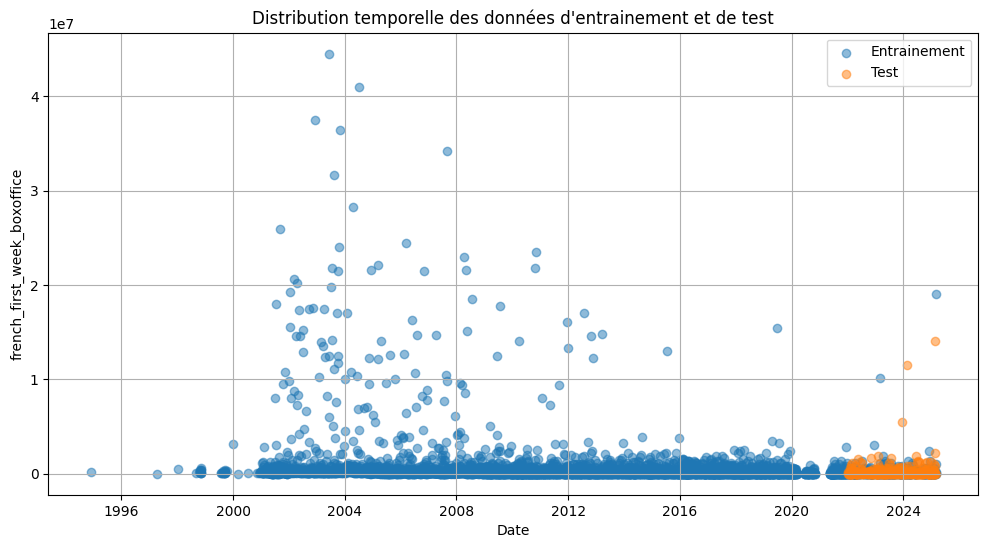

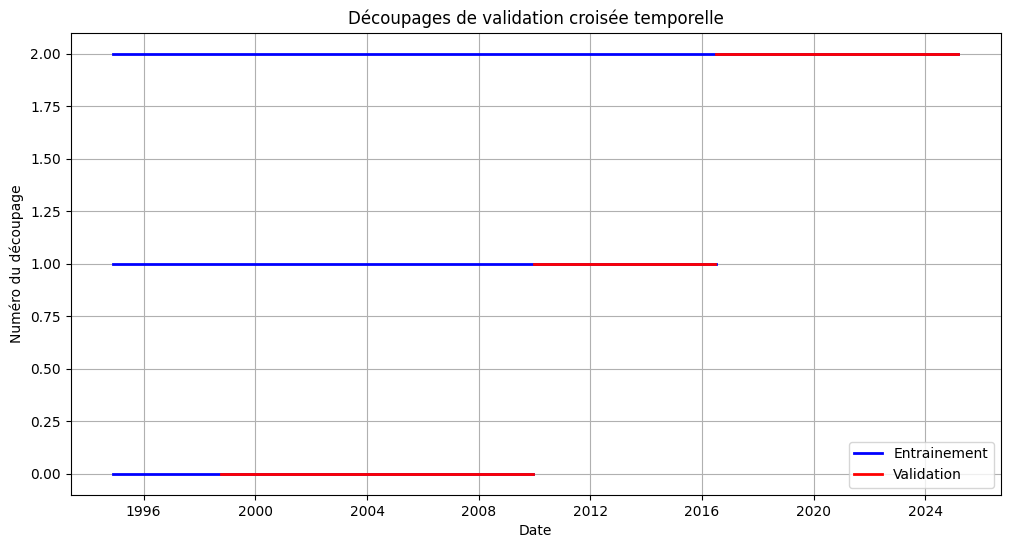

[I 2025-04-23 16:11:22,736] A new study created in memory with name: no-name-a0450479-c743-4397-822a-e73f3765a2c6



Performances du modèle par défaut sur le jeu de test:
MAE: 77183.1204660589
RMSE: 217090.16549635527
R²: 0.936626879002628


[I 2025-04-23 16:11:26,401] Trial 0 finished with value: 1395334.8645953909 and parameters: {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.3, 'subsample': 1.0, 'colsample_bytree': 1.0, 'min_child_weight': 1, 'reg_alpha': 1e-08, 'reg_lambda': 1.0, 'gamma': 0.0, 'scale_pos_weight': 1.0}. Best is trial 0 with value: 1395334.8645953909.
[I 2025-04-23 16:11:27,159] Trial 1 finished with value: 1389834.9576970062 and parameters: {'n_estimators': 60, 'max_depth': 7, 'learning_rate': 0.16505247948986326, 'subsample': 0.8701680867016655, 'colsample_bytree': 0.602168471727063, 'min_child_weight': 4, 'reg_alpha': 5.401771549289639e-05, 'reg_lambda': 3.487873398986844e-08, 'gamma': 0.26566234143560413, 'scale_pos_weight': 1.0409755286925677}. Best is trial 1 with value: 1389834.9576970062.
[I 2025-04-23 16:11:34,548] Trial 2 finished with value: 1184230.4256235035 and parameters: {'n_estimators': 770, 'max_depth': 7, 'learning_rate': 0.067338698769535, 'subsample': 0.8930659055236849, 'c

Meilleurs paramètres trouvés :
    n_estimators: 620
    max_depth: 13
    learning_rate: 0.1680431013395021
    subsample: 0.9477188795095649
    colsample_bytree: 0.7047015872989849
    min_child_weight: 5
    reg_alpha: 2.2881213314088032e-08
    reg_lambda: 0.00025958762892429516
    gamma: 0.3017072728710903
    scale_pos_weight: 1.0103580038751314

Performances du modèle optimisé sur le jeu de test:
MAE: 87902.88483035925
RMSE: 432491.21083808463
R²: 0.7484760362144129


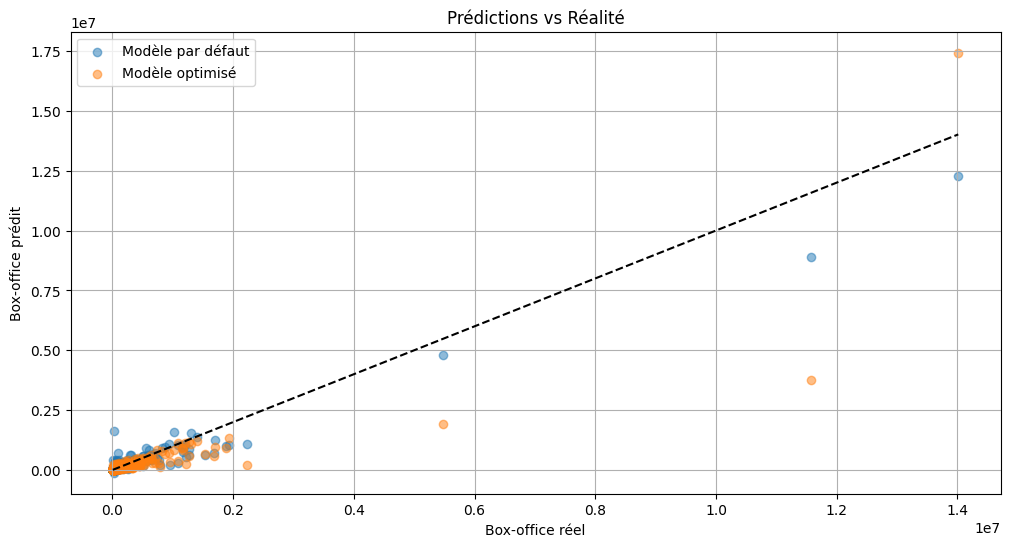

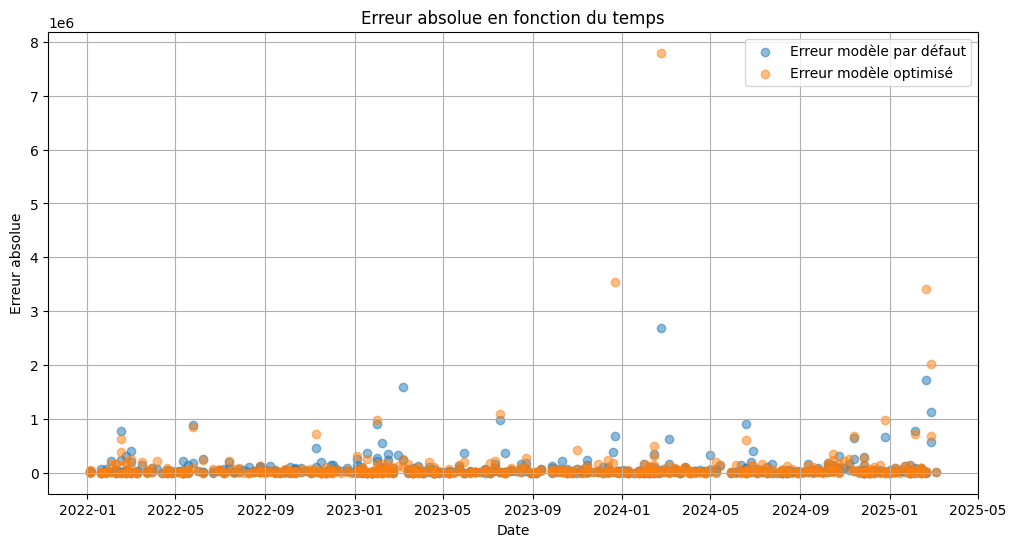

In [56]:
import warnings
warnings.filterwarnings('ignore')

best_model, default_model, study, train_indices, test_indices = optimize_xgboost_time_based(
    df=df, 
    X=X, y=y,
    target_column='french_first_week_boxoffice',
    numerical_features=numerical_features,
    date_feature=date_feature,
    categorical_features=categorical_features,
    list_categorical_features=list_categorical_features,
    test_years=test_years,    
    test_ratio=test_ratio,     
    n_cv_splits=3,     
    n_trials=150        
)

In [ ]:
threshold = y_test.quantile(0.90)
best_idx = y_test[y_test >= threshold].index
X_test_best = X_test.loc[best_idx]
y_test_best = y_test.loc[best_idx]
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test_best)
mae = mean_absolute_error(y_test_best, y_pred)
rmse = root_mean_squared_error(y_test_best, y_pred)
r2 = r2_score(y_test_best, y_pred)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

MAE: 1291264
RMSE: 3209094
R²: 0.2035


MAE: 641102
RMSE: 1056736
R²: 0.8045

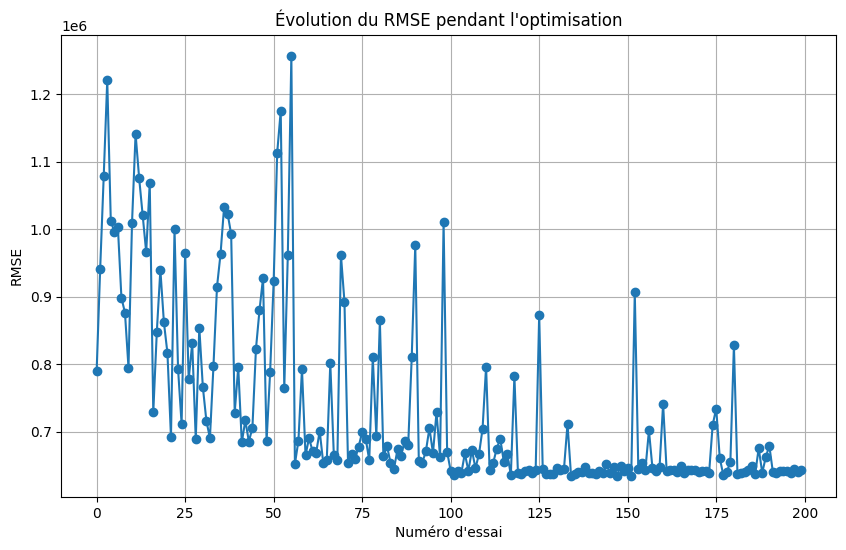

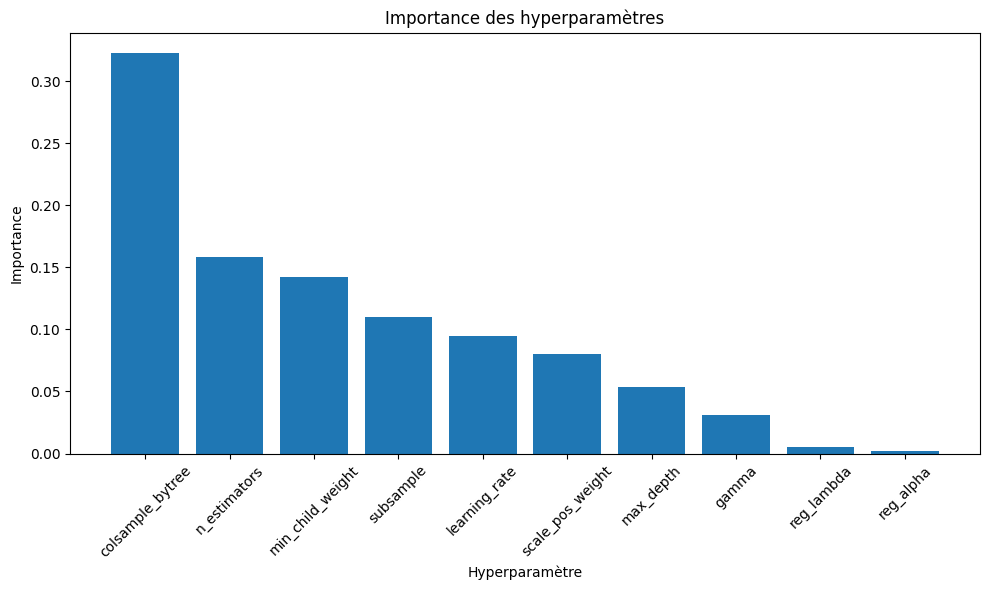

In [ ]:
plot_optimization_history(study)

100%|===================| 5986/6005 [03:43<00:00]        

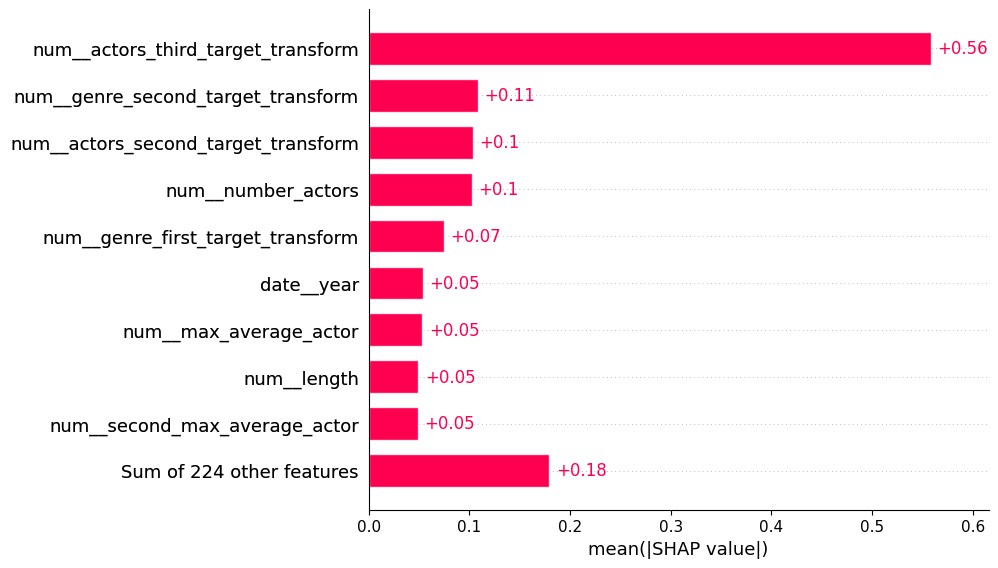

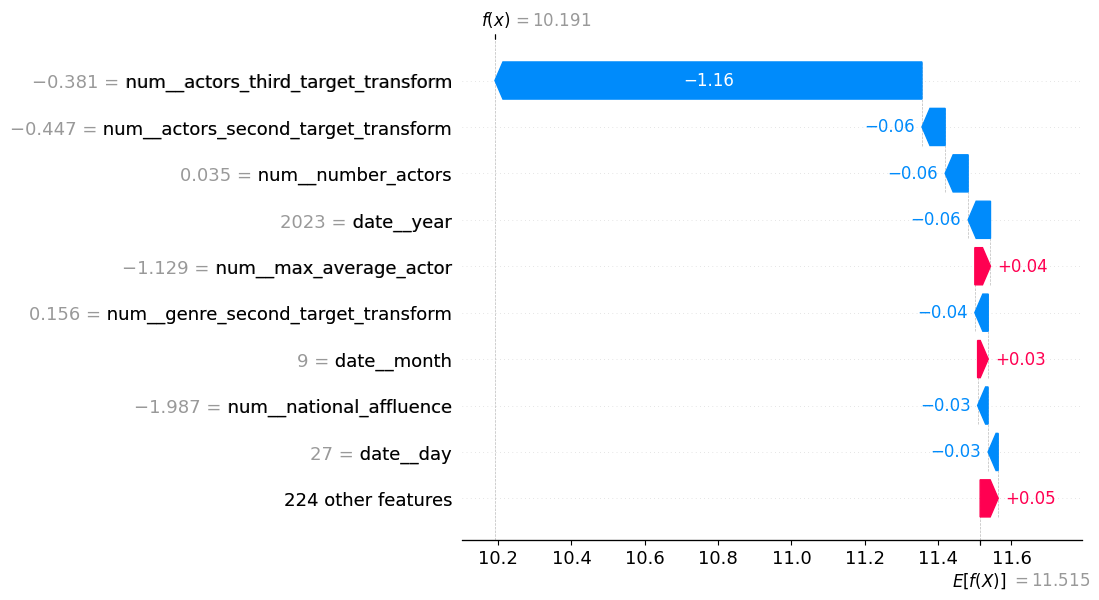

In [ ]:
import shap
import matplotlib.pyplot as plt

# Étape 1 : extraire le preprocessor et le modèle
preprocessor = best_model.named_steps['preprocessor']
xgb_model = best_model.named_steps['xgboost'].regressor_

# Étape 2 : transformer X avec le preprocessor
X_transformed = preprocessor.transform(X).toarray()
feature_names = preprocessor.get_feature_names_out()
X_transformed_df = pd.DataFrame(X_transformed, columns=feature_names)


# Étape 3 : créer l'explainer et calculer les SHAP values
explainer = shap.Explainer(xgb_model, X_transformed_df)
shap_values = explainer(X_transformed_df)

# Étape 4 : visualisation
shap.plots.bar(shap_values)         # importance globale
shap.plots.waterfall(shap_values[0])  # explication locale (ex : ligne 0)


In [ ]:
# Obtenir les noms des features après prétraitement
preprocessor = best_model.named_steps['preprocessor']
feature_names = preprocessor.get_feature_names_out()

# Obtenir les importances
importances = best_model.named_steps['xgboost'].feature_importances_

# Trier par importance décroissante
indices = np.argsort(importances)[::-1]
print(len(indices))
# Afficher les importances
plt.figure(figsize=(12, 8))
plt.title('Importance des features')
plt.bar(range(len(indices)), importances[indices], align='center')
plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

AttributeError: 'TransformedTargetRegressor' object has no attribute 'feature_importances_'

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import pandas as pd

# if hasattr(best_model[-1], 'feature_importances_'):
#     # Obtenir les noms des features après prétraitement
#     preprocessor = best_model.named_steps['preprocessor']
#     feature_names = preprocessor.get_feature_names_out()
    
#     # Obtenir les importances
#     importances = best_model.named_steps['xgboost'].feature_importances_
    
#     # Créer un DataFrame pour faciliter le regroupement
#     importance_df = pd.DataFrame({
#         'feature': feature_names,
#         'importance': importances
#     })
    
#     # Initialiser un dictionnaire pour stocker les importances regroupées
#     grouped_importances = {}
    
#     # Regrouper les features par préfixe
#     for feature, importance in zip(feature_names, importances):
#         if feature.startswith('cat__editor_'):
#             key = 'Éditeur'
#             if key not in grouped_importances:
#                 grouped_importances[key] = 0
#             grouped_importances[key] += importance
#         elif feature.startswith('list__genre_'):
#             key = 'Genre'
#             if key not in grouped_importances:
#                 grouped_importances[key] = 0
#             grouped_importances[key] += importance
#         elif feature.startswith('list__directors_'):
#             key = 'Réalisateur'
#             if key not in grouped_importances:
#                 grouped_importances[key] = 0
#             grouped_importances[key] += importance
#         else:
#             # Garder les autres features telles quelles
#             grouped_importances[feature] = importance
    
#     # Convertir en DataFrame pour le tri et l'affichage
#     grouped_df = pd.DataFrame({
#         'feature': list(grouped_importances.keys()),
#         'importance': list(grouped_importances.values())
#     })
    
#     # Trier par importance décroissante
#     grouped_df = grouped_df.sort_values('importance', ascending=False)
    
#     # Afficher les importances regroupées
#     plt.figure(figsize=(12, 8))
#     plt.title('Importance des features (catégories regroupées)', fontsize=16)
#     plt.bar(range(len(grouped_df)), grouped_df['importance'], align='center')
#     plt.xticks(range(len(grouped_df)), grouped_df['feature'], rotation=45, ha='right', fontsize=12)
#     plt.ylabel('Importance relative', fontsize=14)
#     plt.tight_layout()
#     plt.show()
    
#     # Afficher aussi les résultats sous forme de tableau
#     print("Importance des features regroupées:")
#     for i, row in grouped_df.iterrows():
#         print(f"{row['feature']}: {row['importance']:.4f}")

# push avec mlFlow

In [ ]:
best_params = {
        "n_estimators": best_model.named_steps['xgboost'].n_estimators,
        "max_depth": best_model.named_steps['xgboost'].max_depth,
        "learning_rate": best_model.named_steps['xgboost'].learning_rate,
        "subsample": best_model.named_steps['xgboost'].subsample,
        "colsample_bytree": best_model.named_steps['xgboost'].colsample_bytree,
        "min_child_weight": best_model.named_steps['xgboost'].min_child_weight,
        "reg_alpha": best_model.named_steps['xgboost'].reg_alpha,
        "reg_lambda": best_model.named_steps['xgboost'].reg_lambda,
        "gamma": best_model.named_steps['xgboost'].gamma,
        "scale_pos_weight": best_model.named_steps['xgboost'].scale_pos_weight
    }
best_params

AttributeError: 'TransformedTargetRegressor' object has no attribute 'n_estimators'

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('date', date_transformer, date_feature),
        ('cat', categorical_transformer, categorical_features),
        ('list', list_categorical_transformer, list_categorical_features)
    ],
    remainder='passthrough'
)

model_to_pickle = Pipeline([
    ('preprocessor', preprocessor),  
    ('xgboost', xgb.XGBRegressor())
])

model_to_pickle.fit(X_train,y_train)
y_pred = model_to_pickle.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

MAE: 143651.79834649956
RMSE: 582559.8024282936
R²: 0.7903673735554


In [ ]:
# import mlflow
# import shap
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd
# import json
# import os
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# mlflow.set_experiment('xgb_prediction_box_office')
# mlflow.set_tracking_uri("azureml://francecentral.api.azureml.ms/mlflow/v1.0/subscriptions/72eb7803-e874-44cb-b6d9-33f2fa3eb88c/resourceGroups/vpoutotrg/providers/Microsoft.MachineLearningServices/workspaces/mlstudio-groupe4")

# # Démarrage du run MLflow
# with mlflow.start_run(run_name="XGBoost_Optimized"):
#     # 1. Log des paramètres de préparation des données
#     for key, value in giga_big_param.items():
#         if isinstance(value, list):
#             # Pour les listes, on les convertit en chaîne JSON
#             mlflow.log_param(key, json.dumps(value))
#         else:
#             mlflow.log_param(key, value)
    
#     # 2. Log des hyperparamètres optimisés du modèle
#     best_params = {
#         "n_estimators": best_model.named_steps['xgboost'].n_estimators,
#         "max_depth": best_model.named_steps['xgboost'].max_depth,
#         "learning_rate": best_model.named_steps['xgboost'].learning_rate,
#         "subsample": best_model.named_steps['xgboost'].subsample,
#         "colsample_bytree": best_model.named_steps['xgboost'].colsample_bytree,
#         "min_child_weight": best_model.named_steps['xgboost'].min_child_weight,
#         "reg_alpha": best_model.named_steps['xgboost'].reg_alpha,
#         "reg_lambda": best_model.named_steps['xgboost'].reg_lambda,
#         "gamma": best_model.named_steps['xgboost'].gamma,
#         "scale_pos_weight": best_model.named_steps['xgboost'].scale_pos_weight
#     }
    
#     for param_name, param_value in best_params.items():
#         mlflow.log_param(f"xgb_{param_name}", param_value)
    
#     # 3. Prédictions et calcul des métriques sur le jeu de test
#     y_pred = best_model.predict(X_test)
    
#     mae = mean_absolute_error(y_test, y_pred)
#     rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#     r2 = r2_score(y_test, y_pred)
    
#     # Log des métriques
#     mlflow.log_metric("MAE", mae)
#     mlflow.log_metric("RMSE", rmse)
#     mlflow.log_metric("R2", r2)
    
#     # 4. Calcul et sauvegarde des SHAP values
#     # Transformation des données de test pour l'explication
#     X_test_processed = best_model.named_steps['preprocessor'].transform(X_test)
    
#     # Création d'un explainer SHAP
#     explainer = shap.TreeExplainer(best_model.named_steps['xgboost'])
#     shap_values = explainer.shap_values(X_test_processed)
    
#     # Obtenir les noms des features après prétraitement
#     feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
    
#     # Fonction pour créer le graphique des importances regroupées
#     def plot_grouped_shap_importances(shap_values, feature_names):
#         # Calcul des importances absolues moyennes
#         importances = np.abs(shap_values).mean(axis=0)
        
#         # Créer un DataFrame pour faciliter le regroupement
#         importance_df = pd.DataFrame({
#             'feature': feature_names,
#             'importance': importances
#         })
        
#         # Regrouper les features par préfixe
#         grouped_importances = {}
        
#         for feature, importance in zip(feature_names, importances):
#             if feature.startswith('cat__editor_'):
#                 key = 'Éditeur'
#                 if key not in grouped_importances:
#                     grouped_importances[key] = 0
#                 grouped_importances[key] += importance
#             elif feature.startswith('list__genre_'):
#                 key = 'Genre'
#                 if key not in grouped_importances:
#                     grouped_importances[key] = 0
#                 grouped_importances[key] += importance
#             elif feature.startswith('list__directors_'):
#                 key = 'Réalisateur'
#                 if key not in grouped_importances:
#                     grouped_importances[key] = 0
#                 grouped_importances[key] += importance
#             else:
#                 # Garder les autres features telles quelles
#                 grouped_importances[feature] = importance
        
#         # Convertir en DataFrame pour le tri et l'affichage
#         grouped_df = pd.DataFrame({
#             'feature': list(grouped_importances.keys()),
#             'importance': list(grouped_importances.values())
#         })
        
#         # Trier par importance décroissante
#         grouped_df = grouped_df.sort_values('importance', ascending=False)
        
#         # Création du graphique
#         plt.figure(figsize=(12, 8))
#         plt.title('SHAP Importances (catégories regroupées)', fontsize=16)
#         plt.bar(range(len(grouped_df)), grouped_df['importance'], align='center')
#         plt.xticks(range(len(grouped_df)), grouped_df['feature'], rotation=45, ha='right', fontsize=12)
#         plt.ylabel('Importance SHAP moyenne', fontsize=14)
#         plt.tight_layout()
        
#         # Sauvegarde temporaire du graphique
#         plt.savefig("grouped_shap_importance.png")
#         plt.close()
        
#         return grouped_df
    
#     # Création et sauvegarde du graphique des importances regroupées
#     grouped_importances_df = plot_grouped_shap_importances(shap_values, feature_names)
    
#     # Log du graphique
#     mlflow.log_artifact("grouped_shap_importance.png", "shap_plots")
#     os.remove("grouped_shap_importance.png")  # Nettoyage
    
#     # Log des valeurs d'importance SHAP regroupées sous forme de fichier CSV
#     grouped_importances_df.to_csv("grouped_shap_importances.csv", index=False)
#     mlflow.log_artifact("grouped_shap_importances.csv", "shap_values")
#     os.remove("grouped_shap_importances.csv")  # Nettoyage
    
#     # Création d'un résumé des SHAP values (top 20 features individuelles)
#     shap_importance = pd.DataFrame({
#         'feature': feature_names,
#         'importance': np.abs(shap_values).mean(axis=0)
#     }).sort_values('importance', ascending=False).head(20)
    
#     shap_importance.to_csv("top_shap_features.csv", index=False)
#     mlflow.log_artifact("top_shap_features.csv", "shap_values")
#     os.remove("top_shap_features.csv")  # Nettoyage
    
#     # Log du modèle complet
#     mlflow.sklearn.log_model(best_model, "model")
    
#     # Log des informations sur le jeu de données
#     mlflow.log_param("train_size", len(X_train))
#     mlflow.log_param("test_size", len(X_test))
    
#     print(f"✅ Modèle et artefacts enregistrés avec MLflow - RMSE: {rmse:.3f}")

In [ ]:
# import mlflow
# import mlflow.sklearn
# import shap
# import json
# import os

# from azure.ai.ml import MLClient
# from azure.ai.ml.entities import Model
# from azure.identity import DefaultAzureCredential
# import json
# import pickle
# import os

# # Configuration du client
# ml_client = MLClient(
#     credential=DefaultAzureCredential(),
#     subscription_id="72eb7803-e874-44cb-b6d9-33f2fa3eb88c",
#     resource_group_name="vpoutotrg",
#     workspace_name="mlstudio-groupe4"
# )

# # Enregistrer les paramètres dans un fichier JSON
# giga_big_param_file = "giga_big_param.json"
# with open(giga_big_param_file, "w") as f:
#     json.dump(giga_big_param, f)

# # Enregistrer le modèle dans un fichier pickle
# model_file = "best_model.pkl"
# with open(model_file, "wb") as f:
#     pickle.dump(best_model, f)

# # Calculer et enregistrer les SHAP values
# # ... ton code de calcul des SHAP values ...

# # Sauvegarder le graphique des importances
# plt.figure(figsize=(12, 8))
# # ... ton code pour créer le graphique ...
# plt.savefig("shap_importances.png")
# plt.close()

# # Créer une nouvelle version du modèle dans Azure ML
# model = Model(
#     path=model_file,
#     name="box_office_prediction_model",
#     description="Modèle XGBoost pour prédire les entrées en première semaine",
#     type="custom_model"
# )

# # Chargement des artefacts et métadonnées
# registered_model = ml_client.models.create_or_update(model)

# print(f"✅ Modèle enregistré dans Azure ML avec ID: {registered_model.id}")


# # Définir le nom de l'expérience
# mlflow.set_experiment('prediction_box_office')

# with mlflow.start_run(run_name="XGBoost_Optimized"):
#     # 1. Log des paramètres de préparation des données
#     for key, value in giga_big_param.items():
#         if isinstance(value, list):
#             # Pour les listes, on les convertit en chaîne JSON
#             mlflow.log_param(key, json.dumps(value))
#         else:
#             mlflow.log_param(key, value)
    
#     # 2. Log des hyperparamètres optimisés du modèle
#     best_params = {
#         "n_estimators": best_model.named_steps['xgboost'].n_estimators,
#         "max_depth": best_model.named_steps['xgboost'].max_depth,
#         "learning_rate": best_model.named_steps['xgboost'].learning_rate,
#         "subsample": best_model.named_steps['xgboost'].subsample,
#         "colsample_bytree": best_model.named_steps['xgboost'].colsample_bytree,
#         "min_child_weight": best_model.named_steps['xgboost'].min_child_weight,
#         "reg_alpha": best_model.named_steps['xgboost'].reg_alpha,
#         "reg_lambda": best_model.named_steps['xgboost'].reg_lambda,
#         "gamma": best_model.named_steps['xgboost'].gamma,
#         "scale_pos_weight": best_model.named_steps['xgboost'].scale_pos_weight
#     }
    
#     for param_name, param_value in best_params.items():
#         mlflow.log_param(f"xgb_{param_name}", param_value)
    
#     # 3. Prédictions et calcul des métriques sur le jeu de test
#     y_pred = best_model.predict(X_test)
    
#     mae = mean_absolute_error(y_test, y_pred)
#     rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#     r2 = r2_score(y_test, y_pred)
    
#     # Log des métriques
#     mlflow.log_metric("MAE", mae)
#     mlflow.log_metric("RMSE", rmse)
#     mlflow.log_metric("R2", r2)
    
#     # 4. Calcul et sauvegarde des SHAP values
#     # Transformation des données de test pour l'explication
#     X_test_processed = best_model.named_steps['preprocessor'].transform(X_test)
    
#     # Création d'un explainer SHAP
#     explainer = shap.TreeExplainer(best_model.named_steps['xgboost'])
#     shap_values = explainer.shap_values(X_test_processed)
    
#     # Obtenir les noms des features après prétraitement
#     feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
    
#     # Fonction pour créer le graphique des importances regroupées
#     def plot_grouped_shap_importances(shap_values, feature_names):
#         # Calcul des importances absolues moyennes
#         importances = np.abs(shap_values).mean(axis=0)
        
#         # Créer un DataFrame pour faciliter le regroupement
#         importance_df = pd.DataFrame({
#             'feature': feature_names,
#             'importance': importances
#         })
        
#         # Regrouper les features par préfixe
#         grouped_importances = {}
        
#         for feature, importance in zip(feature_names, importances):
#             if feature.startswith('cat__editor_'):
#                 key = 'Éditeur'
#                 if key not in grouped_importances:
#                     grouped_importances[key] = 0
#                 grouped_importances[key] += importance
#             elif feature.startswith('list__genre_'):
#                 key = 'Genre'
#                 if key not in grouped_importances:
#                     grouped_importances[key] = 0
#                 grouped_importances[key] += importance
#             elif feature.startswith('list__directors_'):
#                 key = 'Réalisateur'
#                 if key not in grouped_importances:
#                     grouped_importances[key] = 0
#                 grouped_importances[key] += importance
#             else:
#                 # Garder les autres features telles quelles
#                 grouped_importances[feature] = importance
        
#         # Convertir en DataFrame pour le tri et l'affichage
#         grouped_df = pd.DataFrame({
#             'feature': list(grouped_importances.keys()),
#             'importance': list(grouped_importances.values())
#         })
        
#         # Trier par importance décroissante
#         grouped_df = grouped_df.sort_values('importance', ascending=False)
        
#         # Création du graphique
#         plt.figure(figsize=(12, 8))
#         plt.title('SHAP Importances (catégories regroupées)', fontsize=16)
#         plt.bar(range(len(grouped_df)), grouped_df['importance'], align='center')
#         plt.xticks(range(len(grouped_df)), grouped_df['feature'], rotation=45, ha='right', fontsize=12)
#         plt.ylabel('Importance SHAP moyenne', fontsize=14)
#         plt.tight_layout()
        
#         # Sauvegarde temporaire du graphique
#         plt.savefig("grouped_shap_importance.png")
#         plt.close()
        
#         return grouped_df
    
#     # Création et sauvegarde du graphique des importances regroupées
#     grouped_importances_df = plot_grouped_shap_importances(shap_values, feature_names)
    
#     # Log du graphique
#     mlflow.log_artifact("grouped_shap_importance.png", "shap_plots")
#     os.remove("grouped_shap_importance.png")  # Nettoyage
    
#     # Log des valeurs d'importance SHAP regroupées sous forme de fichier CSV
#     grouped_importances_df.to_csv("grouped_shap_importances.csv", index=False)
#     mlflow.log_artifact("grouped_shap_importances.csv", "shap_values")
#     os.remove("grouped_shap_importances.csv")  # Nettoyage
    
#     # Création d'un résumé des SHAP values (top 20 features individuelles)
#     shap_importance = pd.DataFrame({
#         'feature': feature_names,
#         'importance': np.abs(shap_values).mean(axis=0)
#     }).sort_values('importance', ascending=False).head(20)
    
#     shap_importance.to_csv("top_shap_features.csv", index=False)
#     mlflow.log_artifact("top_shap_features.csv", "shap_values")
#     os.remove("top_shap_features.csv")  # Nettoyage
    
#     # Log du modèle complet
#     mlflow.sklearn.log_model(best_model, "model")
    
#     # Log des informations sur le jeu de données
#     mlflow.log_param("train_size", len(X_train))
#     mlflow.log_param("test_size", len(X_test))
    
#     print(f"✅ Modèle et artefacts enregistrés avec MLflow - RMSE: {rmse:.3f}")


In [ ]:
import sys
import mlflow
from importlib.metadata import version

print(f"Python version: {sys.version}")
print(f"MLflow version: {version('mlflow')}")
print(f"Azure ML SDK v2 version: {version('azure-ai-ml')}")
print(f"Azure Identity version: {version('azure-identity')}")

# Si installés:
try:
    print(f"Azure ML Core version: {version('azureml-core')}")
except:
    print("Azure ML Core not installed")

try:
    print(f"Azure ML MLflow version: {version('azureml-mlflow')}")
except:
    print("Azure ML MLflow not installed")

Python version: 3.12.3 (main, Feb  4 2025, 14:48:35) [GCC 13.3.0]
MLflow version: 2.21.3
Azure ML SDK v2 version: 1.26.2
Azure Identity version: 1.21.0
Azure ML Core version: 1.59.0.post2
Azure ML MLflow version: 1.59.0.post1


In [ ]:
test = X_test.loc[0].to_json()

In [ ]:
test

'{"french_prod":1,"date":1695772800000,"directors":["C\\u00e9dric Kahn"],"editor":"Ad Vitam","genre":["Policier","Drame","Historique","Judiciaire"],"length":116.0,"number_actors":16,"usa_prod":0,"national_affluence":8.5214285714,"french_langage":1,"english_langage":0,"max_average_actor":0,"sum_score_actor":0}'

In [ ]:
import cloudpickle

model_file = "best_model.pkl"
with open(model_file, "wb") as f:
    cloudpickle.dump(best_model, f)

In [ ]:
endpoint_keys = ml_client.online_endpoints.get_keys(name="luvirasa-prediction-box-office")

print("Primary key:", endpoint_keys.primary_key)
print("Secondary key:", endpoint_keys.secondary_key)

Primary key: 3A6UceXanQchFdQAQZwu3GnNo4OalroVMo49ikSUfqJIJKGV1mLkJQQJ99BDAAAAAAAAAAAAINFRAZML1EDW
Secondary key: C73YYgXyGlJjSLvxijhHKU9Gxu0NKLdaFzL47UF2Xd2Zp5pfAH0cJQQJ99BDAAAAAAAAAAAAINFRAZML3USz
